# MNIST Generation of Labeled Data Experiments

In this notebook, I extract MNIST data and train 3 different sets of DCGANs using each label and a proportion of the original dataset (20%,60%,80%). 
I then use the trained generators to generate labeled data to be used as training data for an EfficientNet classifier.

I first convert all images to 32x32 (from 28x28) and save these images as JPG so that I can have identical input pipelines for the generated images and the original images.

I then train separate DCGAN for each of the classes (0 through 9). Using the generator from the trained DCGAN I then generate 30,000 images for each class and save as JPG.

I then train EfficientNet-B0 models using the generated data and evaluate against the test set. An EfficientNet-B0 model trained on the original dataset augmented with random rotation is used as a benchmark.

In [59]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import PIL
from IPython import display
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import os
import tensorflow_addons as tfa
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [60]:
tf.config.experimental.list_physical_devices('GPU')

gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [61]:
mnist = tfds.load('mnist')
mnist_train = mnist['train']
mnist_test = mnist['test']

In [62]:
#Set distributed training strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [78]:
#Functions used for image & dataset preparation

@tf.function
def prepare_image_minst(item):   
    image = item['image']
    label = item['label']
    image = tf.image.resize(image,size=[32,32])
    image = tf.cast(image, 'float32')
    return image, label

#remove label from batch
def remove_label(image, label):
    return image

#deterimine how many elements in the dataset 
def determine_cardinality(dataset):
    i = 0
    for each in dataset:
        i +=1
    return i

#Update the generated dataset
def update_generated_dataset (image, label):
    image = image * (1./255.)
    image = tf.image.grayscale_to_rgb(image, name=None)
    label = tf.one_hot(label, 10)
    return image, label

#Normalize image to tanh range
def normalize_image (image, label):
    image =  (image - 127.5) / 127.5 # normalize images to -1,1
    return image, label

## Image Augmentation Functions
def transform_image (image):
    image = tfa.image.rotate(image, tf.random.uniform([1],minval=-0.6, maxval=0.6), interpolation='BILINEAR')
    return image

def transform_images (image, label):
    ret_images = [transform_image(image) for i in range(5)]
    labels = [tf.one_hot(label, 10) for i in range(5)]
    return ret_images, labels
    
### Convert to RGB for effnet
def convert_to_rgb (image, label, augment=False):
    image = tf.cast(image, tf.float32)
    image = image * (1./255.)
    image = tf.image.grayscale_to_rgb(image)
    if augment == True:
        image, label = transform_images(image,label)
    else:
        label = tf.one_hot(label, 10)
    return image, label


# First, save all train and test images as resized 32x32x1 images
def resize_and_save_training_data (dataset,label_to_filter):
    directory = 'MNIST/TrainImages/'+str(label_to_filter)+'/'
    filtered_dataset = dataset.map(prepare_image_to_save, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    filtered_dataset = filtered_dataset.filter(lambda x, label: label==label_to_filter)
    count = 0
    for image, label in filtered_dataset:  
        image = image.numpy()
        image = image[:, :, 0]
        image = image.astype(np.uint8)
        image = Image.fromarray(image)
        image.save(directory+str(count)+'.jpg')
        count += 1
    print(count)


##Saves all test images to their folders
def resize_and_save_test_data (dataset,label_to_filter):
    directory = 'MNIST/TestImages/'+str(label_to_filter)+'/'
    filtered_dataset = dataset.map(prepare_image_minst, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    filtered_dataset = filtered_dataset.filter(lambda x, label: label==label_to_filter)
    count = 0
    for image, label in filtered_dataset:  
        image = image.numpy()
        image = image[:, :, 0]
        image = image.astype(np.uint8)
        image = Image.fromarray(image)
        image.save(directory+str(count)+'.jpg')
        count += 1
    print(count)


### creates a dataset that is filtered on the specific label, auugments by randomly rotating
### for dcgan training
def create_minst_dataset(num_to_filter, mnist_train, percentage_to_train_on):
    BUFFER_SIZE = 10000
    BATCH_SIZE = 128 * strategy.num_replicas_in_sync
    mnist_train = mnist_train.map(prepare_image_minst, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    mnist_train = mnist_train.shuffle(BUFFER_SIZE)
    filtered_ds = mnist_train.filter(lambda x, label: label==num_to_filter)
    cardinality = determine_cardinality(filtered_ds)
    filtered_ds = filtered_ds.take(int(cardinality * percentage_to_train_on))
    filtered_ds = filtered_ds.map(transform_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    filtered_ds = filtered_ds.unbatch()
    cardinality = determine_cardinality(filtered_ds)
    print(cardinality)
    filtered_ds = filtered_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    filtered_ds = filtered_ds.map(remove_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    filtered_ds = filtered_ds.batch(BATCH_SIZE)
    filtered_ds = filtered_ds.prefetch(tf.data.experimental.AUTOTUNE)
    return filtered_ds


In [79]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [80]:
#Import DCGAN class
from SourceFiles.ModelSourceFiles.DCGAN import *

#Import Utilities
from SourceFiles.Utilities.Utils import *

# Convert All Images to 32x32 and Save As JPG to Subfolders

In [70]:
# First, save all train and test images as resized 32x32x1 images
for label in range(10):
    resize_and_save_training_data(mnist_train,label)

5923
6742
5958
6131
5842
5421
5918
6265
5851
5949


In [71]:
# First, save all train and test images as resized 32x32x1 images
for label in range(10):
    resize_and_save_test_data(mnist_test,label)

980
1135
1032
1010
982
892
958
1028
974
1009


# Check Function That Creates Dataset Subset

21680


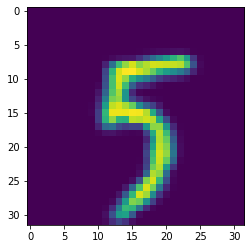

In [78]:
dataset = create_minst_dataset(5,mnist_train, 0.2)
img = dataset.take(1)
for image in img:
    image = image.numpy()
    plt.imshow((image[0, :, :] * 127.5 + 127.5).astype(np.uint8))
plt.show()

# For each label, train a DCGAN against a fraction of the training set using distributed training

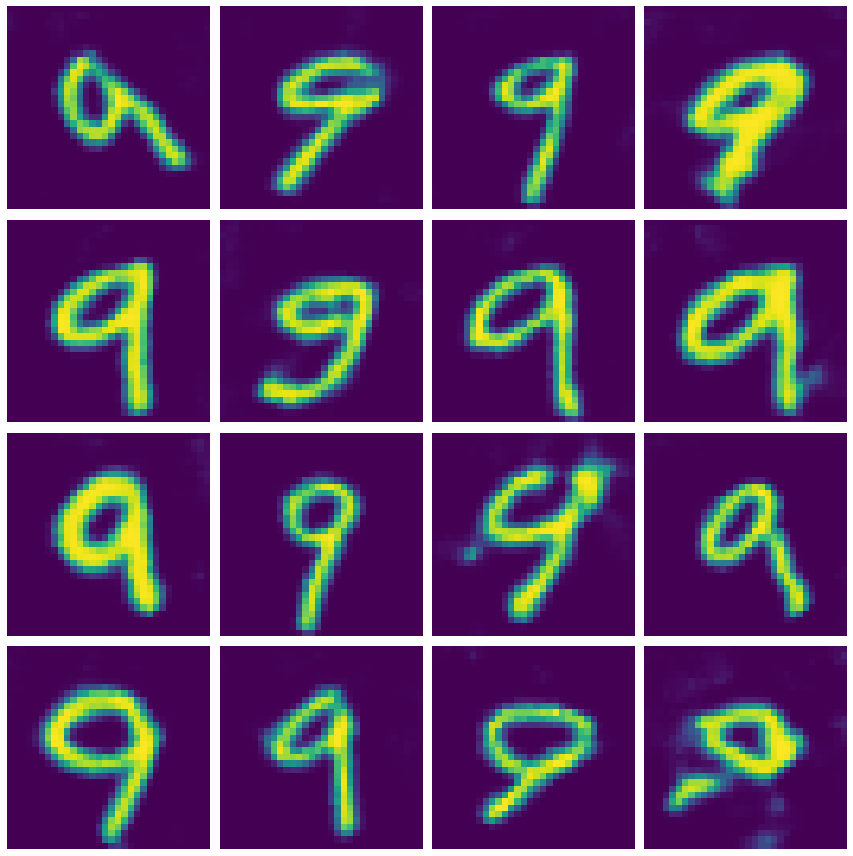

93/93 [==============================] - 5s 58ms/step - Generator_Loss: 0.3915 - Discriminator_Real_Loss: 0.3382 - Discriminator_Generator_Loss: 0.3397 - Average_Discriminator_Loss: 0.3389 - Discriminator_Generator_Accuracy: 0.5999 - Discriminator_Real_Accuracy: 0.5386


In [81]:
%time
## For each number 0 - 9 train a DCGAN 

for label in range(10):
    dataset = create_minst_dataset(label, mnist_train, 0.8) #split off training data for this DCGAN
    with strategy.scope():
        ##Train and save the DCGAN
        generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5) #learning rate by x10
        discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
        
        #Simple generator with leakyrelu
        gen_dict = {'num_latent':100,
                 "filter_num":[128,64],
                 "filter_size":[5,5], 
                 "strides":[2,2],
                 'dense':(8,8,256), 
                 'activation':'leakyrelu', 
                 'out_channels':1,
                 'latent_distribution':'normal'}
        
        
        disc_dict = {"filter_num": [128, 256, 512],
                 "filter_size": [5, 5, 5],
                 'activation': 'leakyrelu',
                 'out_channels': 1,
                 'dropout':0.3,
                 'random_noise':False}
    
        model_name_label = "MNIST_"+str(label)
        
        model = DCGAN(gen_dict=gen_dict, disc_dict=disc_dict, batch_size=128, model_name=model_name_label,
                      distribute=True)
        
        model.compile(generator_optimizer, discriminator_optimizer, 
                      tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                         label_smoothing=0.1,
                                                         reduction =tf.keras.losses.Reduction.NONE))
        model.gen_model.summary()
        model.disc_model.summary()
        save_callback = SaveModelAndCreateImages()
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model.log_path)
        
        #Fit model for 80 epochs each save the models
        model.fit(x=dataset, epochs=80, callbacks=[save_callback,tensorboard_callback],shuffle=True)

        

# 80th generator model for each label is then moved to a dedicated subfolder and named according to a label (e.g. generator for label 4 renamed to 4.h5 and moved to Models_0.8/4.h5)

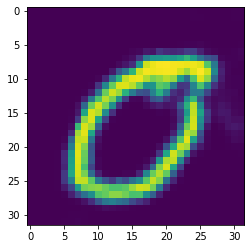

In [82]:
#Load trained models
mnist_models = tf.io.gfile.glob('MNIST/Models_0.8/*.h5')
mnist_models = sorted(mnist_models) 

#Check generator output
Generator = tf.keras.models.load_model(mnist_models[0])
random_img =tf.random.normal([1, 100], stddev=0.2)
each = Generator(random_img, training=False)
each = each.numpy()
plt.imshow((each[0, :, :, :] * 127.5 + 127.5).astype(np.uint8))
plt.show()

# For each label, use the generator to generate 30K images and save them to their associated subdirectory

In [83]:
#For each of the trained DCGAN models, generate labeled training data to train classifier on
Num_images_to_gen = 30000
for idx in range(len(mnist_models)):
    Generator = tf.keras.models.load_model(mnist_models[idx])
    model_path = 'MNIST/Data_0.8/'+str(idx)+'/'
    for img in range(Num_images_to_gen):
        random_img = tf.random.normal([1, 100], stddev=0.2)
        image = Generator(random_img, training=False)
        image = image.numpy()
        image = image[0, :, :, 0] * 127.5 + 127.5
        image = image.astype(np.uint8)
        image = Image.fromarray(image)
        image.save(model_path+str(img)+'.jpg')

# All images have been created, create datasets for original data, generated data and test data

In [90]:
#Using Tensorflow 2.3's image_dataset_from_directory to construct dataset and infer labels from their
Generated_Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'MNIST/Data',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=1,
    image_size=(32, 32),
    shuffle=True,
    interpolation="bilinear",
)

Original_Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'MNIST/TrainImages',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=1,
    image_size=(32, 32),
    shuffle=True,
    interpolation="bilinear"
)


Test_Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'MNIST/TestImages',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=1,
    image_size=(32, 32),
    shuffle=False,
    interpolation="bilinear"
)

Found 300000 files belonging to 10 classes.
Found 60000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


# Convert grayscale images to RGB for EfficientNet model

In [91]:
# No augmentation applied, simply converted to RGB for EfficientNet
Generated_Dataset = Generated_Dataset.unbatch()
Generated_Dataset = Generated_Dataset.map(convert_to_rgb)
Generated_Dataset = Generated_Dataset.shuffle(1337)
Generated_Dataset = Generated_Dataset.batch(512)
Generated_Dataset = Generated_Dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Apply augmentation to original image and convert to RGB

In [38]:
#Apply augmentation to the original dataset, batch and shuffle
Original_Dataset = Original_Dataset.unbatch()
Original_Dataset = Original_Dataset.map(lambda image,label: convert_to_rgb(image, label, augment=True),num_parallel_calls=tf.data.experimental.AUTOTUNE)
Original_Dataset = Original_Dataset.unbatch()
Original_Dataset = Original_Dataset.shuffle(1337)
Original_Dataset = Original_Dataset.batch(512)
Original_Dataset = Original_Dataset.buffer(20000)
Original_Dataset = Original_Dataset.prefetch(tf.data.experimental.AUTOTUNE)


# Prepare Test Dataset

In [94]:
Test_Dataset = Test_Dataset.unbatch()
Test_Dataset = Test_Dataset.map(convert_to_rgb)
Test_Dataset = Test_Dataset.batch(100)


# Check image quality

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


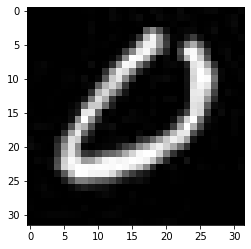

In [125]:
#Check Test images
for img, label in Test_Dataset.take(1):
    img = img.numpy()
    print(label.numpy()[55])
    plt.imshow((img[55, :, :, :]))
plt.show()

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


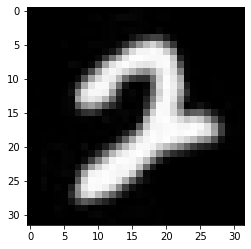

In [106]:
#Check Training Images 
for img, label in Original_Dataset.take(1):
    img = img.numpy()
    print(label.numpy()[125])
    plt.imshow((img[125, :, :, :]))
plt.show()

# Function to create EfficientNet B0 Model
## Custom top, with pretrained imagenet weights, adjusted for 32x32 input.
## This is reusing my model from the kaggle competition.

In [102]:
## Compile EfficientNet B0 Model 

## This is similar to the code I used in the Kaggle Competition
## EfficientNet B0 used as base, imagenet pretrained weights
## Training appears to be volatile (which is not unexpected)

## Below function compiles efficientnetb0 model with custom top (similar model to that used in Kaggle Competition)
def compile_model():    
    ## EfficientNet Base Model
    model_base = tf.keras.applications.EfficientNetB0(include_top=False,
                                                      weights='imagenet',
                                                      input_shape = (32,32,3))
    
    ##Defining the top of the model simple avg pooling -> dropout -> Dense(512) -> Relu -> Softmax
    modeltop = tf.keras.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(512),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Dense(10, activation='softmax', dtype='float32') ])
    
    #SGD worked best as an optimizer for MNIST
    sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.3, nesterov=False) ## Basic SGD appears to work best here
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005, rho=0.9, momentum=0.00, epsilon=1e-07, centered=False,name='RMSprop')
    
    # Define the full model and compile
    full_model = tf.keras.Model(inputs=model_base.input, outputs=modeltop(model_base.output))
    loss = tf.keras.losses.CategoricalCrossentropy() 
    full_model.compile(optimizer=sgd,loss=loss,metrics=['accuracy'])
    
    return full_model

# Train EfficientNetB0 Model On Original Full Dataset

In [46]:
#Distributed Training was used
with strategy.scope():
    Original_model = compile_model()
    Original_model.fit(x=Original_Dataset, shuffle=True, epochs=40)

Epoch 1/40
INFO:tensorflow:batch_all_reduce: 215 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 215 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 215 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 215 all-reduces with algorithm = nccl, num_packs = 1


586/586 [==============================] - 27s 47ms/step - loss: 1.9749 - accuracy: 0.3269
Epoch 2/40
586/586 [==============================] - 27s 46ms/step - loss: 1.1652 - accuracy: 0.6363
Epoch 3/40
586/586 [==============================] - 27s 46ms/step - loss: 0.7488 - accuracy: 0.7774
Epoch 4/40
586/586 [==============================] - 27s 47ms/step - loss: 0.5435 - accuracy: 0.8376
Epoch 5/40
586/586 [==============================] - 27s 47ms/step - loss: 0.4351 - accuracy: 0.8691
Epoch 6/40
586/586 [==============================] - 27s 47ms/step - loss: 0.3670 - accuracy: 0.8893
Epoch 7/40
586/586 [==============================] - 27s 47ms/step - loss: 0.3261 - accuracy: 0.9012
Epoch 8/40
586/586 [==============================] - 27s 47ms/step - loss: 0.2925 - accuracy: 0.9109
Epoch 9/40
586/586 [==============================] - 27s 47ms/step - loss: 0.2691 - accuracy: 0.9191
Epoch 10/40
586/586 [==============================] - 27s 47ms/step - loss: 0.2493 - accurac

# Train EfficientNet Model On Generated Dataset

In [103]:
with strategy.scope():
    Generated_model = compile_model()
    Generated_model.fit(x=Generated_Dataset, shuffle=True, epochs=40)

Epoch 1/40
586/586 [==============================] - 31s 53ms/step - loss: 2.0398 - accuracy: 0.2949
Epoch 2/40
586/586 [==============================] - 31s 53ms/step - loss: 1.2272 - accuracy: 0.6164
Epoch 3/40
586/586 [==============================] - 31s 53ms/step - loss: 0.7675 - accuracy: 0.7756
Epoch 4/40
586/586 [==============================] - 31s 53ms/step - loss: 0.5408 - accuracy: 0.8412
Epoch 5/40
586/586 [==============================] - 31s 53ms/step - loss: 0.4218 - accuracy: 0.8757
Epoch 6/40
586/586 [==============================] - 31s 53ms/step - loss: 0.3541 - accuracy: 0.8943
Epoch 7/40
586/586 [==============================] - 32s 54ms/step - loss: 0.3094 - accuracy: 0.9079
Epoch 8/40
586/586 [==============================] - 31s 53ms/step - loss: 0.2755 - accuracy: 0.9179
Epoch 9/40
586/586 [==============================] - 32s 54ms/step - loss: 0.2462 - accuracy: 0.9270
Epoch 10/40
586/586 [==============================] - 31s 54ms/step - loss: 0.224

# Evaluate Model Performance

In [47]:
Original_model.evaluate(Test_Dataset)

100/100 [==============================] - 1s 12ms/step - loss: 0.1851 - accuracy: 0.9438


[0.18514300882816315, 0.9437999725341797]

In [104]:
Generated_model.evaluate(Test_Dataset)

100/100 [==============================] - 1s 12ms/step - loss: 0.0738 - accuracy: 0.9796


[0.07384414970874786, 0.9796000123023987]